#DATA PREPROCESSING

In [25]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import col, isnan, when, count, isnull
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
import numpy as np

In [28]:
spark = SparkSession.builder.appName("EDA").getOrCreate()
df = spark.read.csv('/content/Assignment-1_Data.csv', sep=';',header = True)
df.printSchema()

root
 |-- BillNo: string (nullable = true)
 |-- Itemname: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [5]:
df.show()

+------+--------------------+--------+----------------+-----+----------+--------------+
|BillNo|            Itemname|Quantity|            Date|Price|CustomerID|       Country|
+------+--------------------+--------+----------------+-----+----------+--------------+
|536365|WHITE HANGING HEA...|       6|01.12.2010 08:26| 2,55|     17850|United Kingdom|
|536365| WHITE METAL LANTERN|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|CREAM CUPID HEART...|       8|01.12.2010 08:26| 2,75|     17850|United Kingdom|
|536365|KNITTED UNION FLA...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|RED WOOLLY HOTTIE...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|SET 7 BABUSHKA NE...|       2|01.12.2010 08:26| 7,65|     17850|United Kingdom|
|536365|GLASS STAR FROSTE...|       6|01.12.2010 08:26| 4,25|     17850|United Kingdom|
|536366|HAND WARMER UNION...|       6|01.12.2010 08:28| 1,85|     17850|United Kingdom|
|536366|HAND WARMER RED P...|   

In [29]:
print((df.count(), len(df.columns)))

(522064, 7)


In [30]:
for col_name in df.columns:
    unique_values = df.select(col_name).distinct().rdd.flatMap(lambda x: x).collect()
    print(f"Unique values in {col_name}: {len(unique_values)}")

Unique values in BillNo: 21663
Unique values in Itemname: 4186
Unique values in Quantity: 690
Unique values in Date: 19641
Unique values in Price: 1285
Unique values in CustomerID: 4298
Unique values in Country: 30


In [31]:
summary1 = df.summary().toPandas()
summary1

,summary,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,count,522064,520609,522064,522064,522064,388023,522064
1,mean,559950.7852856276,None,10.090435272303779,None,15.576812289966394,15316.931710233672,None
2,stddev,13452.75089984722,None,161.11052518229152,None,72.62169390055651,1721.846964266427,None
3,min,536365,"""ASSORTED FLOWER COLOUR """"LEIS""""""",-1,01.02.2011 08:23,"-11062,06",12346,Australia
4,25%,547888.0,None,1.0,None,0.0,13951.0,None
5,50%,560601.0,None,3.0,None,0.0,15265.0,None
6,75%,571890.0,None,10.0,None,18.0,16837.0,None
7,max,A563187,wrongly sold sets,992,31.10.2011 17:19,"99,96",18287,Unspecified


Missing Values

In [32]:
missing_counts = df.select([count(when(isnull(c) | isnan(c), c)).alias(c) for c in df.columns])
missing_counts.show()

+------+--------+--------+----+-----+----------+-------+
|BillNo|Itemname|Quantity|Date|Price|CustomerID|Country|
+------+--------+--------+----+-----+----------+-------+
|     0|    1455|       0|   0|    0|    134041|      0|
+------+--------+--------+----+-----+----------+-------+



Filling Null values in CustomerID with 999999

In [33]:
df = df.fillna(999999,subset='CustomerID')

In [34]:
summary2 = df.describe().toPandas()
summary2

,summary,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,count,522064,520609,522064,522064,522064,388023,522064
1,mean,559950.7852856276,None,10.090435272303779,None,15.576812289966394,15316.931710233672,None
2,stddev,13452.75089984722,None,161.11052518229152,None,72.62169390055651,1721.846964266427,None
3,min,536365,"""ASSORTED FLOWER COLOUR """"LEIS""""""",-1,01.02.2011 08:23,"-11062,06",12346,Australia
4,max,A563187,wrongly sold sets,992,31.10.2011 17:19,"99,96",18287,Unspecified


We can see that min Quantity is -1 which is not possible.

In [35]:
df.filter(df.Quantity<=0).show()

+------+--------+--------+----------------+-----+----------+--------------+
|BillNo|Itemname|Quantity|            Date|Price|CustomerID|       Country|
+------+--------+--------+----------------+-----+----------+--------------+
|536589|    null|     -10|01.12.2010 16:50|    0|      null|United Kingdom|
|536764|    null|     -38|02.12.2010 14:42|    0|      null|United Kingdom|
|536996|    null|     -20|03.12.2010 15:30|    0|      null|United Kingdom|
|536997|    null|     -20|03.12.2010 15:30|    0|      null|United Kingdom|
|536998|    null|      -6|03.12.2010 15:30|    0|      null|United Kingdom|
|537000|    null|     -22|03.12.2010 15:32|    0|      null|United Kingdom|
|537001|    null|      -6|03.12.2010 15:33|    0|      null|United Kingdom|
|537003|    null|      -2|03.12.2010 15:33|    0|      null|United Kingdom|
|537004|    null|     -30|03.12.2010 15:34|    0|      null|United Kingdom|
|537005|    null|     -70|03.12.2010 15:35|    0|      null|United Kingdom|
|537006|    

Filtering out these rows as we can see it is noise in the data.

In [36]:
df = df.filter(df.Quantity>0)
df.show()

+------+--------------------+--------+----------------+-----+----------+--------------+
|BillNo|            Itemname|Quantity|            Date|Price|CustomerID|       Country|
+------+--------------------+--------+----------------+-----+----------+--------------+
|536365|WHITE HANGING HEA...|       6|01.12.2010 08:26| 2,55|     17850|United Kingdom|
|536365| WHITE METAL LANTERN|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|CREAM CUPID HEART...|       8|01.12.2010 08:26| 2,75|     17850|United Kingdom|
|536365|KNITTED UNION FLA...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|RED WOOLLY HOTTIE...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|SET 7 BABUSHKA NE...|       2|01.12.2010 08:26| 7,65|     17850|United Kingdom|
|536365|GLASS STAR FROSTE...|       6|01.12.2010 08:26| 4,25|     17850|United Kingdom|
|536366|HAND WARMER UNION...|       6|01.12.2010 08:28| 1,85|     17850|United Kingdom|
|536366|HAND WARMER RED P...|   

Checking Null Values in Itemnames

In [14]:
missing_counts = df.select([count(when(isnull('Itemname') | isnan('Itemname'), 'Itemname')).alias('Itemname')])
missing_counts.show()

+--------+
|Itemname|
+--------+
|     135|
+--------+



Removing rows where Itemnames is missing

In [37]:
df = df.dropna()

In [38]:
# NUll values
df.select([count(when(isnull(c) | isnan(c), c)).alias(c) for c in df.columns]).show()

+------+--------+--------+----+-----+----------+-------+
|BillNo|Itemname|Quantity|Date|Price|CustomerID|Country|
+------+--------+--------+----+-----+----------+-------+
|     0|       0|       0|   0|    0|         0|      0|
+------+--------+--------+----+-----+----------+-------+



In [39]:
df = df.withColumn('Price', regexp_replace('Price', ',', '.'))
df = df.withColumn('Total_Price', round(df.Price * df.Quantity, 2))
df = df.withColumn('Hour', split('Date', ' ')[1])
df = df.withColumn('Date', split('Date', ' ')[0])
df = df.withColumn( 'Date', concat_ws('-', split('Date', '\.')[2], split('Date', '\.')[1], split('Date', '\.')[0]))
df = df.withColumn('Date', to_date('Date'))
df.show()

+------+--------------------+--------+----------+-----+----------+--------------+-----------+-----+
|BillNo|            Itemname|Quantity|      Date|Price|CustomerID|       Country|Total_Price| Hour|
+------+--------------------+--------+----------+-----+----------+--------------+-----------+-----+
|536365|WHITE HANGING HEA...|       6|2010-12-01| 2.55|     17850|United Kingdom|       15.3|08:26|
|536365| WHITE METAL LANTERN|       6|2010-12-01| 3.39|     17850|United Kingdom|      20.34|08:26|
|536365|CREAM CUPID HEART...|       8|2010-12-01| 2.75|     17850|United Kingdom|       22.0|08:26|
|536365|KNITTED UNION FLA...|       6|2010-12-01| 3.39|     17850|United Kingdom|      20.34|08:26|
|536365|RED WOOLLY HOTTIE...|       6|2010-12-01| 3.39|     17850|United Kingdom|      20.34|08:26|
|536365|SET 7 BABUSHKA NE...|       2|2010-12-01| 7.65|     17850|United Kingdom|       15.3|08:26|
|536365|GLASS STAR FROSTE...|       6|2010-12-01| 4.25|     17850|United Kingdom|       25.5|08:26|


#EDA

Finding best selling items in countries(Quantity)

In [40]:
#df_sql = sqlCtx.createDataFrame(df_market)
sqlCtx = SQLContext(spark)
df.createOrReplaceTempView("df")
itemname_by_country = sqlCtx.sql("""SELECT Country, Itemname, SUM(Quantity) as Quantity, SUM(Total_Price) as TotPrice FROM df GROUP BY Country, Itemname""")
itemname_by_country.createOrReplaceTempView("itemname_by_country")

top_product_country = sqlCtx.sql("""SELECT Country, Itemname, Quantity FROM 
    (SELECT Country, Itemname, Quantity, MAX(Quantity) OVER(PARTITION BY Country) AS Max_Quant FROM itemname_by_country)
    WHERE Quantity=MAX_QUANT
    """)

print("Best sellers by country")
top_product_country.orderBy('Quantity', ascending=False).show(15, truncate=False)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Best sellers by country
+--------------+-----------------------------------+--------+
|Country       |Itemname                           |Quantity|
+--------------+-----------------------------------+--------+
|United Kingdom|PAPER CRAFT , LITTLE BIRDIE        |80995.0 |
|Netherlands   |RABBIT NIGHT LIGHT                 |4801.0  |
|France        |RABBIT NIGHT LIGHT                 |4000.0  |
|Japan         |RABBIT NIGHT LIGHT                 |3408.0  |
|Australia     |MINI PAINT SET VINTAGE             |2952.0  |
|Sweden        |MINI PAINT SET VINTAGE             |2916.0  |
|Germany       |ROUND SNACK BOXES SET OF4 WOODLAND |1233.0  |
|Spain         |CHILDRENS CUTLERY POLKADOT PINK    |729.0   |
|Switzerland   |PLASTERS IN TIN WOODLAND ANIMALS   |636.0   |
|Norway        |SMALL FOLDING SCISSOR(POINTED EDGE)|576.0   |
|Belgium       |PACK OF 72 RETROSPOT CAKE CASES    |480.0   |
|Singapore     |CHRISTMAS TREE PAINTED ZINC        |384.0   |
|Austria       |SET 12 KIDS COLOUR  CHALK STIC

Finding best earning countries(Total Price)

In [41]:
tot_price_by_country = sqlCtx.sql("""SELECT Country, ROUND(SUM(TotPrice), 2) AS TotPrice FROM itemname_by_country GROUP BY Country""")

print("Total gain by country")
tot_price_by_country_pd = tot_price_by_country.orderBy('TotPrice', ascending=False).toPandas()

tot_price_by_country_pd.head(40)

Total gain by country


,Country,TotPrice
0,United Kingdom,7308391.55
1,Netherlands,285446.34
2,Germany,228867.14
3,France,209024.05
4,Australia,138521.31
5,Spain,61577.11
6,Switzerland,56443.95
7,Belgium,41196.34
8,Sweden,38378.33
9,Japan,37416.37


Country vs Total Price 

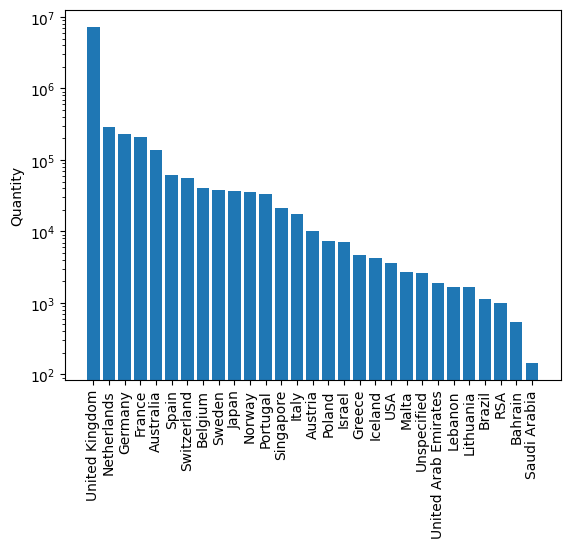

In [42]:
x = tot_price_by_country_pd['Country']
y = tot_price_by_country_pd['TotPrice']

plt.bar(x, y)
plt.yscale('log')
plt.ylabel('Quantity')
plt.xticks(rotation=90)
plt.show()

Quantity vs Total Price analysis

In [43]:
items_quantity = sqlCtx.sql("""SELECT Itemname, SUM(Quantity) as Quantity, SUM(TotPrice) as TotPrice FROM itemname_by_country GROUP BY Itemname""")
items_quantity_df = items_quantity.toPandas()

items_quantity_df = items_quantity_df.sort_values(by='Quantity', ascending=False)

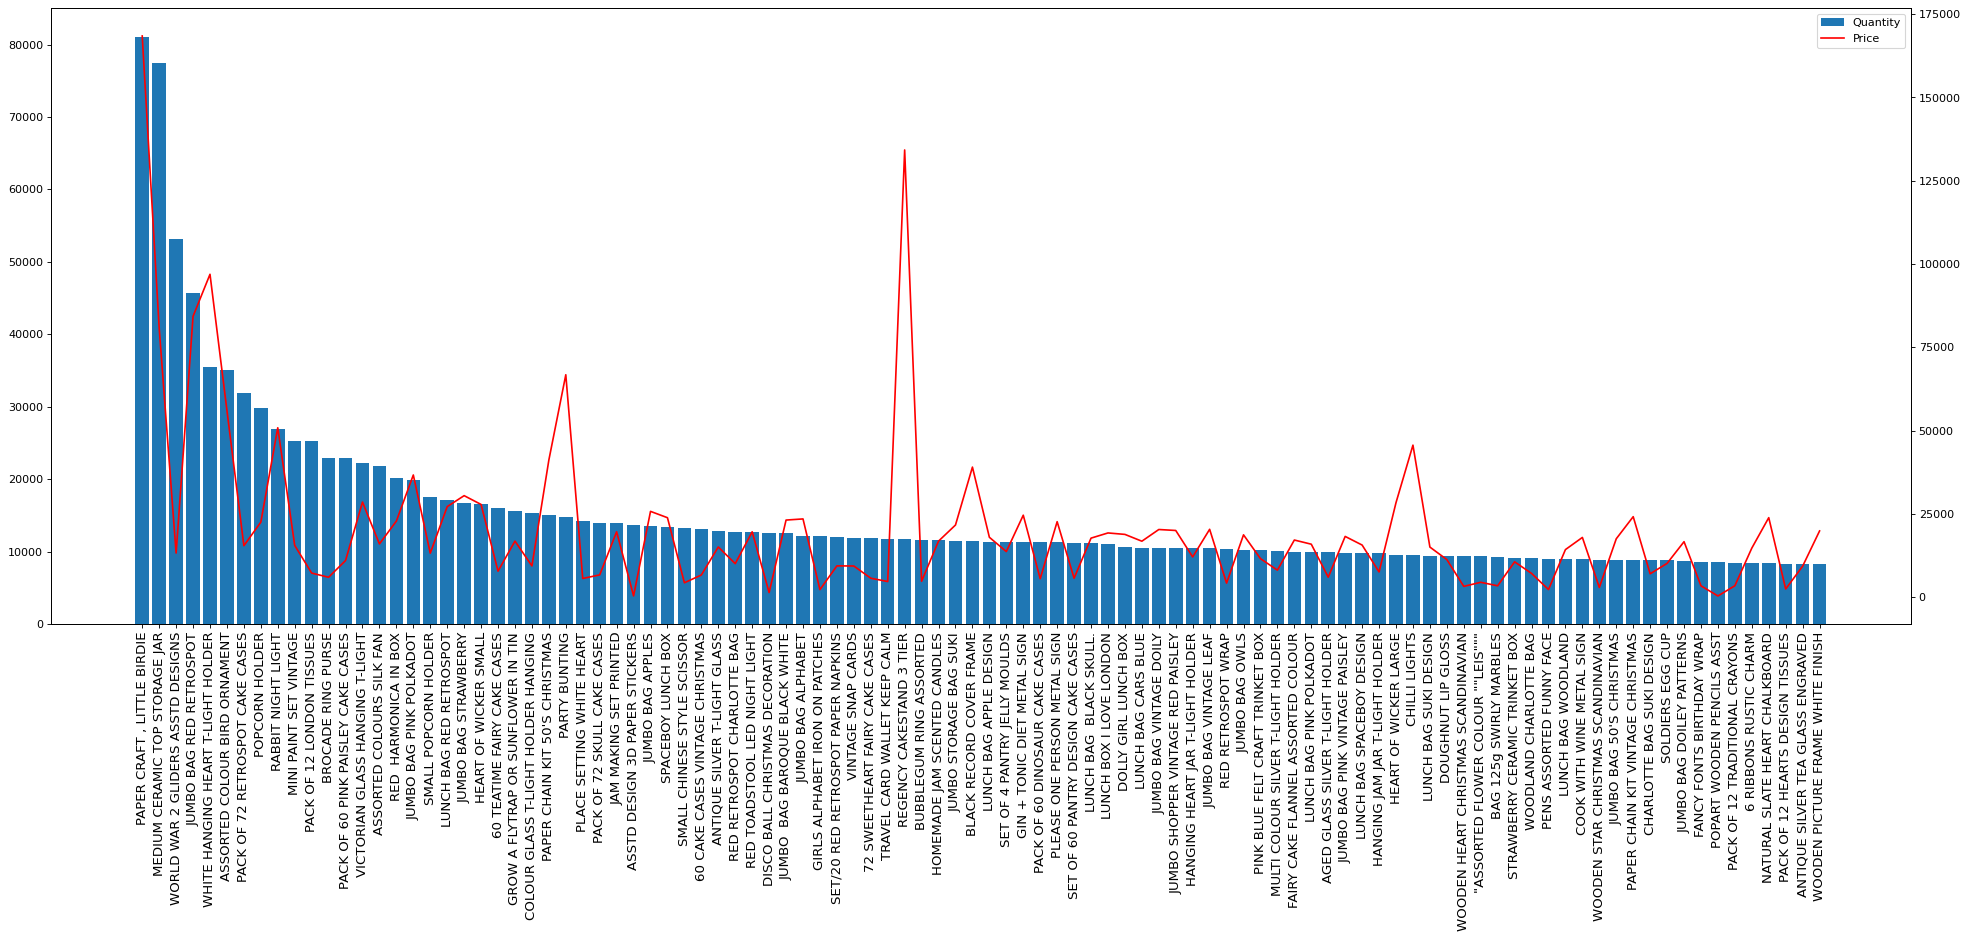

In [44]:
ntop = 100

x = items_quantity_df['Itemname'][:ntop]
quant = items_quantity_df['Quantity'][:ntop]
price = items_quantity_df['TotPrice'][:ntop]
plt.figure(figsize=(30, 10), dpi=80)

ax1 = plt.subplot()
l1 = ax1.bar(x, quant, label='Quantity')
plt.xticks(rotation=90, fontsize=12)

ax2 = ax1.twinx()
l2, = ax2.plot(x, price, label='Price', color='r')
plt.legend([l1, l2], ["Quantity", "Price"])
plt.show()


The above chart represents the quantity of items sold (bars) and the total gain for each item. We can see that the items which give the more gain are not always the ones which are sold in large quantity

**Displaying CustomerIDs with highest bill value**

     CustomerID         Country  TotPrice
0         12600         Germany   2599.04
1         14667  United Kingdom   9241.20
2         14553  United Kingdom    859.27
3         17774  United Kingdom   1225.41
4         15869  United Kingdom    149.64
...         ...             ...       ...
4295      15659  United Kingdom    306.45
4296      15385  United Kingdom    316.88
4297      16366  United Kingdom    327.30
4298      13348  United Kingdom    233.76
4299      15604  United Kingdom    216.39

[4300 rows x 3 columns]
     CustomerID         Country   TotPrice
1609      14646     Netherlands  280206.02
2672      18102  United Kingdom  259657.30
159       17450  United Kingdom  194550.79
8         16446  United Kingdom  168472.50
1306      12415       Australia  124914.53
...         ...             ...        ...
1256      17956  United Kingdom      12.75
3738      16454  United Kingdom       6.90
4112      14792  United Kingdom       6.20
1912      16738  United Kingdom       3.7

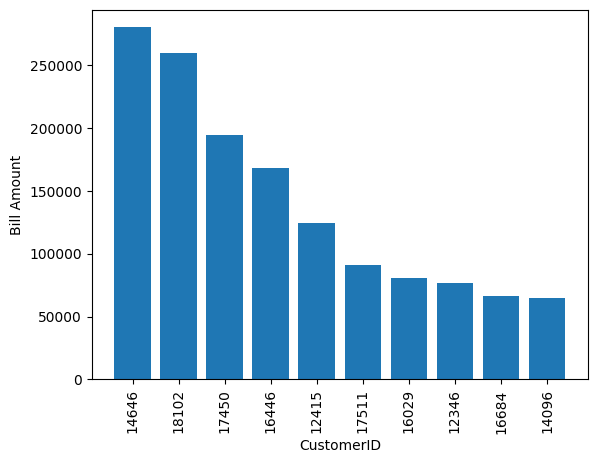

In [45]:
expense_per_customer = sqlCtx.sql("""SELECT CustomerID, Country, SUM(Total_Price) as TotPrice FROM df WHERE CustomerID <> 99999 GROUP BY CustomerID, Country""")
expense_per_customer_pd = expense_per_customer.toPandas()
print(expense_per_customer_pd)
expense_per_customer_pd = expense_per_customer_pd.sort_values(by='TotPrice', ascending=False)
ex = expense_per_customer_pd.head(10)
print(expense_per_customer_pd)
print(ex)

x = ex['CustomerID']
y = ex['TotPrice']

plt.bar(x, y)
plt.xlabel('CustomerID')
plt.ylabel('Bill Amount')
plt.xticks(rotation=90)
plt.show()

Visualization by a histogram 

<ipython-input-46-ecf913530bc2>:2: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot((np.log10(expense_per_customer_pd['TotPrice'][expense_per_customer_pd['TotPrice']>0])), bw=0.1, color='r')


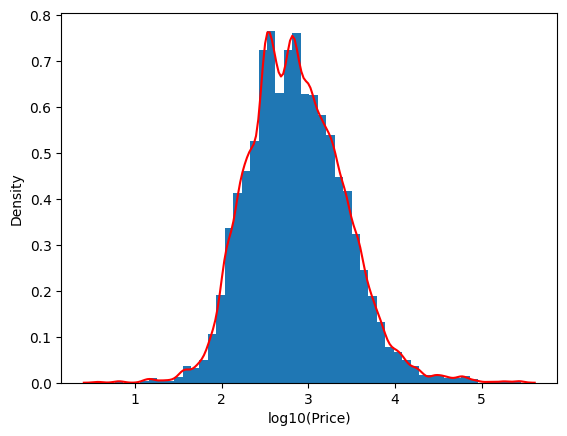

In [46]:
plt.hist(np.log10(expense_per_customer_pd['TotPrice'][expense_per_customer_pd['TotPrice']>0]), bins=50, density=True)
sns.kdeplot((np.log10(expense_per_customer_pd['TotPrice'][expense_per_customer_pd['TotPrice']>0])), bw=0.1, color='r')
plt.xlabel('log10(Price)')
plt.show()

We note that the distribution of the expenses per customer is symmetrical, with two peeks, in a log scale.